In [1]:
import zarr
import matplotlib.pyplot as plt
import numpy as np

## Basic zarr handling

1. Open your OME-NGFF zarr and look at the info

In [2]:
z = zarr.open('/projects/researchit/djme/zarr_dask_examples/zarrs/histopath_example.zarr', mode='r')
z.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,0
No. groups,3
Groups,"0, 1, 2"


2. Check the bioformats2raw layout version

In [3]:
z.attrs['bioformats2raw.layout']

3

3. This zarr was created from an NDPI file, which outputs three images, which is why there are three groups. Only the first image has the raw data we are looking for, so let's take a look at the info for that:

In [4]:
z['0'].info

Name,/0
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,10
No. arrays,10
No. groups,0
Arrays,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9"


4. This "image" is still considered a group, because zarrs produced by `bioformats2raw` are multiscale. Thus each of these ten arrays is a pyramid (resolution) level. The `0` array is full resolution, `1` is 1/2 scale along the x and y axes, `2` is 1/4 scale, and so on. Let's take a look at a few:

In [5]:
z['0/0'].info  # Full resolution pyramid level

Name,/0/0
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 48896, 109440)"
Chunk shape,"(1, 1, 1, 4096, 4096)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,16053534720 (15.0G)
No. bytes stored,8183684947 (7.6G)


In [6]:
z['0/1'].info  # 1/2 scale along x and y

Name,/0/1
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 24448, 54720)"
Chunk shape,"(1, 1, 1, 4096, 4096)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,4013383680 (3.7G)
No. bytes stored,2491282483 (2.3G)


In [7]:
z['0/2'].info  # 1/4 scale along x and y

Name,/0/2
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 12224, 27360)"
Chunk shape,"(1, 1, 1, 4096, 4096)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1003345920 (956.9M)
No. bytes stored,692602393 (660.5M)


5. Let's dive into the full resolution array:

In [8]:
zim = z['0/0']
type(zim)

zarr.core.Array

In [9]:
zim.shape

(1, 3, 1, 48896, 109440)

In [10]:
zim.chunks

(1, 1, 1, 4096, 4096)

In [11]:
zim.nchunks

972

6. Slicing a zarr returns a numpy array

In [12]:
zim[0,0,0,:50,:50]

array([[235, 235, 235, ..., 235, 237, 237],
       [235, 235, 235, ..., 235, 237, 237],
       [235, 235, 235, ..., 235, 237, 237],
       ...,
       [236, 236, 236, ..., 236, 237, 237],
       [235, 235, 235, ..., 235, 237, 236],
       [235, 235, 235, ..., 235, 237, 236]], dtype=uint8)

In [13]:
type(zim[0,0,0,:50,:50])

numpy.ndarray

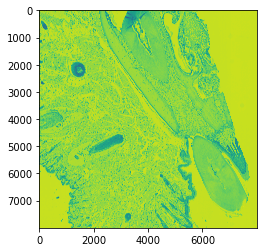

In [14]:
plt.imshow(zim[0,0,0,10000:18000,16000:24000]);

7. This is actually an RGB image. `matplotlib` can handle that, but we need to reshape

In [15]:
rgb_zim = np.moveaxis(zim[0,:,0,10000:18000,16000:24000], 0, -1)
rgb_zim.shape

(8000, 8000, 3)

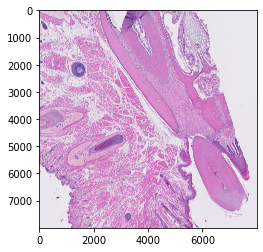

In [16]:
plt.imshow(rgb_zim);

8. Precomputed pyramids are great for when you don't need full resolution data, e.g., if you want to take a look at a global view of the whole slide

In [17]:
zim_small = z['0/7']  # remember that the second group in the path is pyramid level
zim_small.shape

(1, 3, 1, 382, 855)

In [18]:
zim_small_array = np.moveaxis(zim_small[0,:,0,:,:], 0, -1)
zim_small_array.shape

(382, 855, 3)

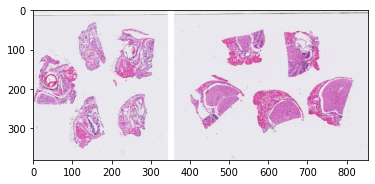

In [19]:
plt.imshow(zim_small_array);

9. We can also load a zarr from object storage over the internet. Here is the same image loaded from some S3-compatible object storage. Note that we are specifying the full resolution image, not the top level zarr group:

In [20]:
za = zarr.open('http://s3-far.jax.org/zarrtest/histopath_example.zarr/0/0', mode='r')
za.info

Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 48896, 109440)"
Chunk shape,"(1, 1, 1, 4096, 4096)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,16053534720 (15.0G)
Chunks initialized,0/972


10. This new zarr loaded over http can be used just like the one we loaded from the filesystem.

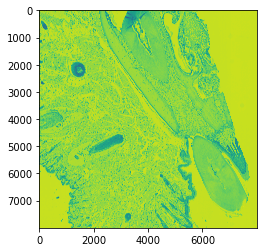

In [21]:
plt.imshow(za[0,0,0,10000:18000,16000:24000]);

## Using OME-NGFF/zarr for exploring high content screening data

11. Plate data can also be converted to an OME-NGFF zarr! Like our slide scan example, plates are also zarr groups, with the top level group indicating row. In this example, we have 8 rows of wells:

In [22]:
plate = zarr.open('/projects/researchit/djme/zarr_dask_examples/zarrs/plate_example.zarr/', mode='r')
plate.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,8
No. arrays,0
No. groups,8
Groups,"0, 1, 2, 3, 4, 5, 6, 7"


12. And we have 12 columns of wells:

In [23]:
plate['0'].info

Name,/0
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,12
No. arrays,0
No. groups,12
Groups,"0, 1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9"


13. When selecting info for a specific well (i.e., specifying both row and column of the plate in the path), you find that the well itself is also a group. This grouping contains "fields", which are independent images taken of a single well. This well has 25 fields:

In [24]:
plate['0/0'].info

Name,/0/0
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,25
No. arrays,0
No. groups,25
Groups,"0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 3, 4, 5, 6, 7, 8, 9"


14. The next level down is your multiscale level, so selecting '0' for that will give you your image:

In [25]:
plate['0/0/0/0'].info

Name,/0/0/0/0
Type,zarr.core.Array
Data type,>u2
Shape,"(1, 3, 1, 1080, 1080)"
Chunk shape,"(1, 1, 1, 1080, 1080)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,6998400 (6.7M)
No. bytes stored,6665226 (6.4M)


15. zarr groups give you useful iterators that can be used to loop over your data. Here is how you might loop over all of the fields in a well:

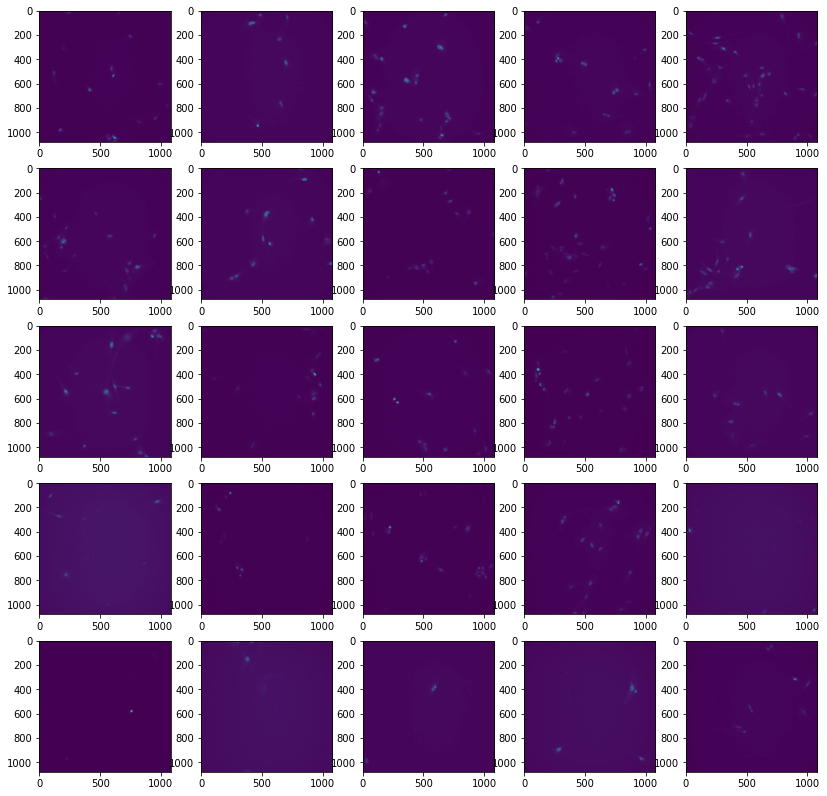

In [26]:
_, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))

for field_index, field in plate['2/2'].groups():
    field_index = int(field_index)  # Because this starts as a string
    axes.flatten()[field_index].imshow(field['0'][0,0,0,:,:]);